# Sound wave in LBM

The lattice in LBM is a compressible medium with the lattice speed of sound. It is 

$$ c_s = \frac{1}{\sqrt 3}$$

in `D2Q9` model.

We can observe this wave by following density disturbance in steady fluid. 

First we setup a simulation on square domain with noslip walls. The initial condition will be the fluid at rest except one node - `32,1` where we set $\rho=1.1$.

We can expect the wave propagating from this node to the right wall.







In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os

sys.path.append( os.path.join(os.environ.get("HOME"),"sailfish") ) 

datapath = os.path.join( "/dev/shm/",os.environ.get("USER"),"data")
try:
    os.makedirs(datapath,mode=0755)
except OSError as ex:
    print datapath,"::",ex.strerror

if not os.path.isdir('data') and os.path.islink('data'):
    os.remove("data")
    
if not os.path.islink('data'):
    os.symlink(datapath, "data")

%env BASH_ENV= ~/.bash_profile

/dev/shm/marcin.kostur/data :: File exists
env: BASH_ENV=~/.bash_profile


In [2]:
%%writefile ex5.py

import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hy == self.gy-1) & (hx == self.gx-1) &(hx==0)&(hy==0)  )
        
        self.set_node(wall_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        nx,ny = self.gx,self.gy
        sim.rho[:] = 1.0
        sim.rho[32,1] = 1.1
        
class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Writing ex5.py


In [3]:
%%bash
export PYTHONPATH=$PWD/sailfish/
python ex5.py --max_iters=100 --every=1 \
 --lat_nx=63 --lat_ny=63 \
 --model=mrt \
 --visc=0.001 \
 --output=./data/ex5 --output_format=npy

[   674  INFO Master/gpu4.smcebi.us.edu.pl] Machine master starting with PID 98561 at 2017-02-28 10:55:44 UTC
[   674  INFO Master/gpu4.smcebi.us.edu.pl] Simulation started with: ex5.py --max_iters=100 --every=1 --lat_nx=63 --lat_ny=63 --model=mrt --visc=0.001 --output=./data/ex5 --output_format=npy
[   689  INFO Master/gpu4.smcebi.us.edu.pl] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   689  INFO Master/gpu4.smcebi.us.edu.pl] Handling subdomains: [0]
[   689  INFO Master/gpu4.smcebi.us.edu.pl] Subdomain -> GPU map: {0: 0}
[   689  INFO Master/gpu4.smcebi.us.edu.pl] Selected backend: cuda
[   985  INFO Subdomain/0] Initializing subdomain.
[   987  INFO Subdomain/0] Required memory: 
[   987  INFO Subdomain/0] . distributions: 0 MiB
[   987  INFO Subdomain/0] . fields: 0 MiB
[  3197  INFO Subdomain/0] Starting simulation.
[  3712  INFO Subdomain/0] Simulation completed after 100 iterations.


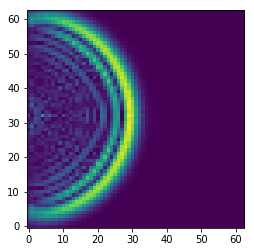

In [5]:
data = np.load("data/ex5.0.050.npz")
vx,vy = data['v']
rho = data['rho']
plt.imshow(np.sqrt(vy**2+vx**2),origin='top')

Rho 0.99952 1.00058


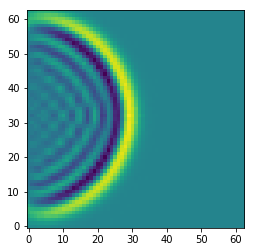

In [6]:
print "Rho",np.nanmin(rho),np.nanmax(rho)
plt.imshow(rho,origin='top')

In [7]:
import glob
frames = []

for fn in sorted(glob.glob("data/ex5*.npz")):
    data = np.load(fn)
    vx,vy = data['v']
    rho = data['rho']
    #vx, vy  = vx[s],vy[s]
    Dxvx,Dyvx = np.gradient(vx)
    Dxvy,Dyvy = np.gradient(vy)
    frames.append([vx, vy,Dyvx-Dxvy,rho])
print "Read ",(len(frames)),"files"

Read  101 files


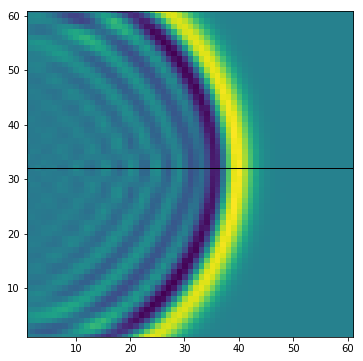

In [8]:
from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
#from IPython.display import display,clear_output
ny,nx = frames[0][0].shape
@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          figsize=widgets.IntSlider(min=0,max=20,value=6),\
          sel=widgets.Dropdown(options={'vx':0, 'vy': 1, 'rot v': 2,'rho':3},value=0))
def g(ith,figsize,sel):
    
    plt.figure(figsize=(figsize,float(ny)/nx*figsize))
    vx,vy=frames[ith][:2]
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel],origin='top')
    plt.axhline(y=32, xmin=0, xmax=40, linewidth=1, color = 'k')
    plt.show()

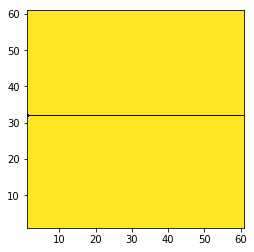

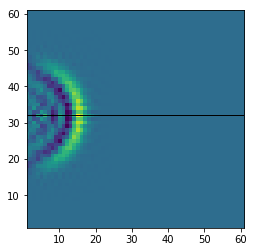

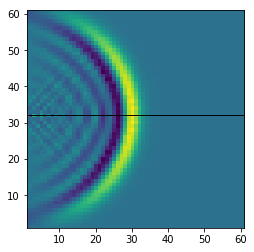

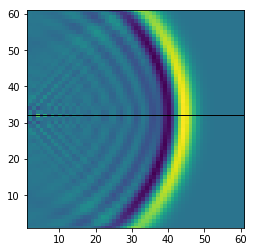

In [17]:
for i in range(1,len(frames),25):
    g(i,4,0)

### Speed of sound - numerical measurement 

We can estimate numerically the speed of sound and compare it with a analitical value $\frac{1}{\sqrt 3}$

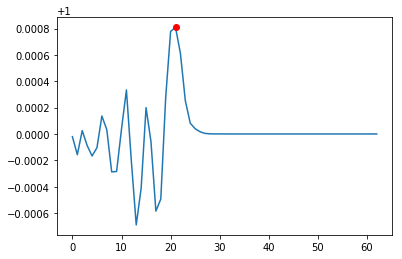

In [11]:
ith = 35
f_ = frames[ith]
imax = np.argmax(f_[3][32,:])
plt.plot(f_[3][32,:])
plt.plot( imax,f_[3][32,imax],'ro')

0.583142545173 0.57735026919


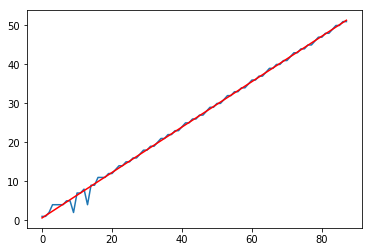

In [12]:
y = [np.argmax(f_[3][32,:]) for f_ in frames[1:-12]] 
x = np.arange(len(y))
a,b = np.polyfit(x, y, 1)
plt.plot(x,y )
plt.plot(x,a*x+b,'r')
print a,1/np.sqrt(3)